In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bayesnet as bn

np.random.seed(1234)

In [2]:
x_train = np.linspace(-3, 3, 10)[:, None]
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=x_train.shape)

In [3]:
class NeuralNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        with self.set_parameter():
            self.w1 = np.random.randn(n_input, n_hidden)
            self.b1 = np.zeros(n_hidden)
            self.w2 = np.random.randn(n_hidden, n_output)
            self.b2 = np.zeros(n_output)

    def __call__(self, x, y=None):
        h = bn.tanh(x @ self.w1 + self.b1)
        mu = h @ self.w2 + self.b2
        self.py = bn.random.Gaussian(mu, 0.1, data=y)
        return mu.value

In [4]:
model = NeuralNetwork(1, 20, 1)
optimizer = bn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)

for _ in range(10000):
    model.clear()
    model(x_train, y_train)
    log_likelihood = model.log_pdf()
    log_likelihood.backward()
    optimizer.update()

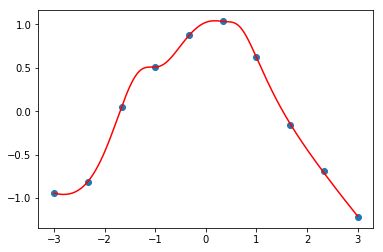

In [5]:
x = np.linspace(-3, 3, 1000)[:, None]
plt.scatter(x_train, y_train)
plt.plot(x, model(x), c="r")
plt.show()

In [6]:
class RegularizedNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        with self.set_parameter():
            self.w1 = np.random.randn(n_input, n_hidden)
            self.b1 = np.zeros(n_hidden)
            self.w2 = np.random.randn(n_hidden, n_output)
            self.b2 = np.zeros(n_output)

    def __call__(self, x, y=None):
        self.pw1 = bn.random.Gaussian(0, 1, data=self.w1)
        self.pb1 = bn.random.Gaussian(0, 1, data=self.b1)
        self.pw2 = bn.random.Gaussian(0, 1, data=self.w2)
        self.pb2 = bn.random.Gaussian(0, 1, data=self.b2)
        h = bn.tanh(x @ self.w1 + self.b1)
        mu = h @ self.w2 + self.b2
        self.py = bn.random.Gaussian(mu, 0.1, data=y)
        return mu.value

In [7]:
model = RegularizedNetwork(1, 20, 1)
optimizer = bn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)

for _ in range(10000):
    model.clear()
    model(x_train, y_train)
    log_posterior = model.log_pdf()
    log_posterior.backward()
    optimizer.update()

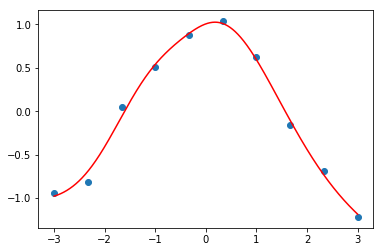

In [8]:
x = np.linspace(-3, 3, 1000)[:, None]
plt.scatter(x_train, y_train)
plt.plot(x, model(x), c="r")
plt.show()

In [9]:
class BayesianNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        with self.set_parameter(), self.set_prior_dist():
            self.w1_mu = np.zeros((n_input, n_hidden))
            self.w1_s = np.zeros((n_input, n_hidden))
            self.b1_mu = np.zeros(n_hidden)
            self.b1_s = np.zeros(n_hidden)
            self.w2_mu = np.zeros((n_hidden, n_output))
            self.w2_s = np.zeros((n_hidden, n_output))
            self.b2_mu = np.zeros(n_output)
            self.b2_s = np.zeros(n_output)
            self.prior = bn.random.Gaussian(0, 1)

    def __call__(self, x, y=None):
        self.qw1 = bn.random.Gaussian(
            self.w1_mu, bn.softplus(self.w1_s),
            p=self.prior
        )
        self.qb1 = bn.random.Gaussian(
            self.b1_mu, bn.softplus(self.b1_s),
            p=self.prior
        )
        self.qw2 = bn.random.Gaussian(
            self.w2_mu, bn.softplus(self.w2_s),
            p=self.prior
        )
        self.qb2 = bn.random.Gaussian(
            self.b2_mu, bn.softplus(self.b2_s),
            p=self.prior
        )
        h = bn.tanh(x @ self.qw1.draw() + self.qb1.draw())
        mu = h @ self.qw2.draw() + self.qb2.draw()
        self.py = bn.random.Gaussian(mu, 0.1, data=y)
        if y is None:
            return self.py.draw().value

In [10]:
model = BayesianNetwork(1, 20, 1)
optimizer = bn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)

for _ in range(10000):
    model.clear()
    model(x_train, y_train)
    elbo = model.elbo()
    elbo.backward()
    optimizer.update()

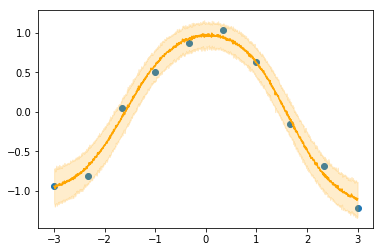

In [11]:
x = np.linspace(-3, 3, 1000)[:, None]
plt.scatter(x_train, y_train)
y = [model(x) for _ in range(100)]
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
plt.plot(x, y_mean, c="orange")
plt.fill_between(x.ravel(), (y_mean - y_std).ravel(), (y_mean + y_std).ravel(), color="orange", alpha=0.2)
plt.show()